<a href="https://colab.research.google.com/github/quynhu-d/hse_risk_management_1/blob/main/notebooks/RM_part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект

## Библиотеки

In [ ]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import yfinance as yf

import sys
import warnings
warnings.simplefilter("ignore")
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = '/content/drive/MyDrive/RM_project/'

In [ ]:
random_seed = 42
np.random.RandomState(seed=random_seed)

RandomState(MT19937) at 0x7FBB1E7A9740

In [ ]:
from stoch_models import *
from data_stats import reduce_with_pca

## Загрузка данных

In [ ]:
data = pd.read_excel(folder+'Final_data.xlsx')
# data = pd.read_excel('./Final_data.xlsx')

In [ ]:
print(data.shape, '\n')

print(data.columns, '\n')

(2922, 32) 

Index(['Date', 'Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС',
       'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 0.5', 'КБД 1', 'КБД 5',
       'КБД 10', 'КБД 15', 'КБД 20', 'КБД 30', 'ОФЗ_26207', 'ОФЗ_26215',
       'ОФЗ_26218', 'ОФЗ_26219', 'ОФЗ_26222', 'Аэрофлот', 'Газпром',
       'ГМК Норникель', 'Лукойл', 'МТС', 'ПИК', 'Роснефть', 'Сбербанк',
       'Татнефть', 'Яндекс'],
      dtype='object') 



In [ ]:
# Заполнение пропусков
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

### Разбиение данных

In [ ]:
def split_data(df, split_date, start_date=None, end_date=None):
    train = df[df.Date <= split_date]
    test = df[df.Date > split_date]
    if start_date is not None:
        train = train[train.Date >= start_date]
    if end_date is not None:
        test = test[test.Date <= end_date]
    return train, test

In [ ]:
#разбиваем данные на train и test по дате

#df_train, df_test = split_data(data, split_date='2022-06-09')
#print(df_train.shape[0], df_test.shape[0])

2717 205


## Часть 4: оценка справедливой стоимости

Портфель состоит из инструментов.\
Инструменты:
1. Облигации (5 шт. по 10 млн.руб.)
2. Акции (10 шт. по 1 млн. руб.)
3. Валюта (доллар и евро, по 100 млн. руб.)

Риск-факторы влияют на стоимость инструментов.

In [ ]:
def calculate_score(y_true, y_pred_N, mode='mape'):
    res = []
    if mode == 'rmse':
        for y_sim in y_pred_N:
            res.append(mean_squared_error(y_true, y_sim, squared=False))
        return np.mean(res)
    elif mode == 'mae':
        for y_sim in y_pred_N:
            res.append(mean_absolute_error(y_true, y_sim))
        return np.mean(res)
    elif mode == 'mape':
        for y_sim in y_pred_N:
            res.append(mean_absolute_percentage_error(y_true, y_sim))
        return np.mean(res)
    else:
        return None

Для предсказания стоимости по риск-факторам используются линейная регрессия и LightGBM. Также стоимость считается на основе стохастических моделей из пункта 3.

In [ ]:
def make_predictions_LR(X_train, y_train, X_test):
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def make_predictions_boosting(X_train, y_train, X_test, metric):
    params = {
        'objective': 'regression',
        'metric': metric,
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train, y_train)
    model = lgb.train(params, train_data, verbose_eval=False)
    y_pred = model.predict(X_test)
    return y_pred

In [ ]:
class Fair_value_measurement:
    def __init__(self, target_name, factors_name,
                 df, last_date,
                 n_steps=10, N_traj=100,
                 metric='mape', use_pca=False,
                 models=None):

        self.target_name = target_name
        self.risk_factors = factors_name
        self.df = df
        self.train, self.test = split_data(df, split_date=last_date)
        self.n_steps = n_steps
        self.N_traj = N_traj

        if models is not None:
            self.models = models
        else:
            self.models = ['stoch_model', 'LinReg', 'LGBM']
        self.colors = {'stoch_model':'steelblue', 'LinReg':'plum', 'LGBM':'seagreen'}

        # метрики
        self.metric = metric
        self.metric_res = {}

        self.factors_sim = self.make_simulations_for_risk_factors(self.metric)

        self.predictions = {}
        self.predicted = False
        self.use_pca = use_pca

    def make_simulations_for_risk_factors(self, metric='mape'):
        # симулируется n траекторий для каждого риск-фактора на t шагов вперед
        dt = np.diff(list(self.df.index))
        dW_corr = generate_dW_corr(self.df[self.risk_factors], dt=dt, w0=0, N_traj=self.N_traj)

        df_res = {}
        for factor, dWn in tqdm(zip(self.risk_factors, dW_corr), total=len(self.risk_factors)):
            sm = Stoch_Models(factor_name=factor,
                  value_train = self.train[factor].values, value_test = self.test[factor].values,
                  t_train = list(self.train.index), t_test = list(self.test.index),
                  models=['m1', 'm2', 'm3'], N_traj=self.N_traj, dW_N=dWn)
            sm.choose_model(metric=metric, plot_all=0, plot_best=0, print_metric=0)
            df_res[factor] = sm.future_simulation(n_steps=self.n_steps, plot=0)

        return df_res

    def make_x_test(self, i_traj):
        # формируем x_test из симуляций риск-факторов
        x_test = pd.DataFrame(index=self.test.index[:self.n_steps])
        for factor in self.factors_sim.keys():
            x_test[factor] = self.factors_sim[factor][i_traj]
        return x_test

    def reduce_data_dim(self, data, is_train=False):
        # PCA
        if is_train:
            reduced, pca = reduce_with_pca(data, fraction=10)
            self.pca_fitted = pca
            print('Data reduced, old shape:', data.shape, 'new shape:', reduced.shape)
        else:
            reduced = self.pca_fitted.transform(data)
        return reduced

    def calc_metric(self):
        y_test = self.test[self.target_name].values[:self.n_steps]
        for m in self.models:
            self.metric_res[m] = calculate_score(y_test, self.predictions[m], self.metric)

    def plot_predictions(self, fig_size=(18, 6)):
        fig, axs = plt.subplots(1, 1, figsize=fig_size)

        for m in self.models:
            axs.plot(self.test.index[:self.n_steps], self.predictions[m].T, color=self.colors[m], linewidth=0.5)
            axs.plot(self.test.index[:self.n_steps], np.mean(self.predictions[m], axis=0), color=self.colors[m], linewidth=0.5, label=m)

        axs.plot(self.test.index[:self.n_steps], self.test[self.target_name].values[:self.n_steps], color='black', linewidth=1.5, label='target')

        axs.legend()
        axs.set_title(f'{self.target_name}')
        plt.show()

    def make_predictions(self, plot=0):
        self.predicted = True
        x_train = self.train[self.risk_factors]
        if self.use_pca:
            x_train = self.reduce_data_dim(x_train, is_train=True)
        y_train = self.train[self.target_name]
        y_test = self.test[self.target_name].values[:self.n_steps]

        # ЛинРег + LGBM
        y_pred_lr = []
        y_pred_lgbm = []
        for i in range(0, self.N_traj):
            x_test = self.make_x_test(i)
            if self.use_pca:
                x_test = self.reduce_data_dim(x_test, is_train=False)
            y_pred1 = make_predictions_LR(x_train, y_train, x_test)
            y_pred_lr.append(np.array(y_pred1))
            y_pred2 = make_predictions_boosting(x_train, y_train, x_test, self.metric)
            y_pred_lgbm.append(np.array(y_pred2))

        self.predictions['LinReg'] = np.array(y_pred_lr)
        #self.metric_res = calculate_score(y_test, self.predictions, self.metric)
        self.predictions['LGBM'] = np.array(y_pred_lgbm)

        # Стох. модель
        sm_tg = Stoch_Models(factor_name=self.target_name,
                  value_train = self.train[self.target_name].values, value_test = self.test[self.target_name].values,
                  t_train = list(self.train.index), t_test = list(self.test.index),
                  models=['m1', 'm2', 'm3'], N_traj=self.N_traj)
        sm_tg.choose_model(metric=self.metric, plot_all=0, plot_best=0, print_metric=0)
        self.predictions['stoch_model'] = sm_tg.future_simulation(n_steps=self.n_steps, plot=0)

        self.calc_metric()
        if plot==1:
            self.plot_predictions()

    def find_best_model(self):
        min_m = min(self.metric_res.values())
        best_model = None
        for m in self.models:
            if self.metric_res[m] == min_m:
                best_model = m
        return best_model

    def get_best_prediction(self, choosen_model=None):
        if self.predicted == False:
            self.make_predictions()
        if choosen_model is None or choosen_model not in self.models:
            choosen_model = self.find_best_model()
        return self.predictions[choosen_model]

### Валюта

In [ ]:
risk_factors_1 = ['Нефть', 'МосБиржа', 'РТС', 'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 1', 'КБД 5', 'КБД 10', 'КБД 20']

currency = ['Курс доллара', 'Курс евро']

  0%|          | 0/11 [00:00<?, ?it/s]

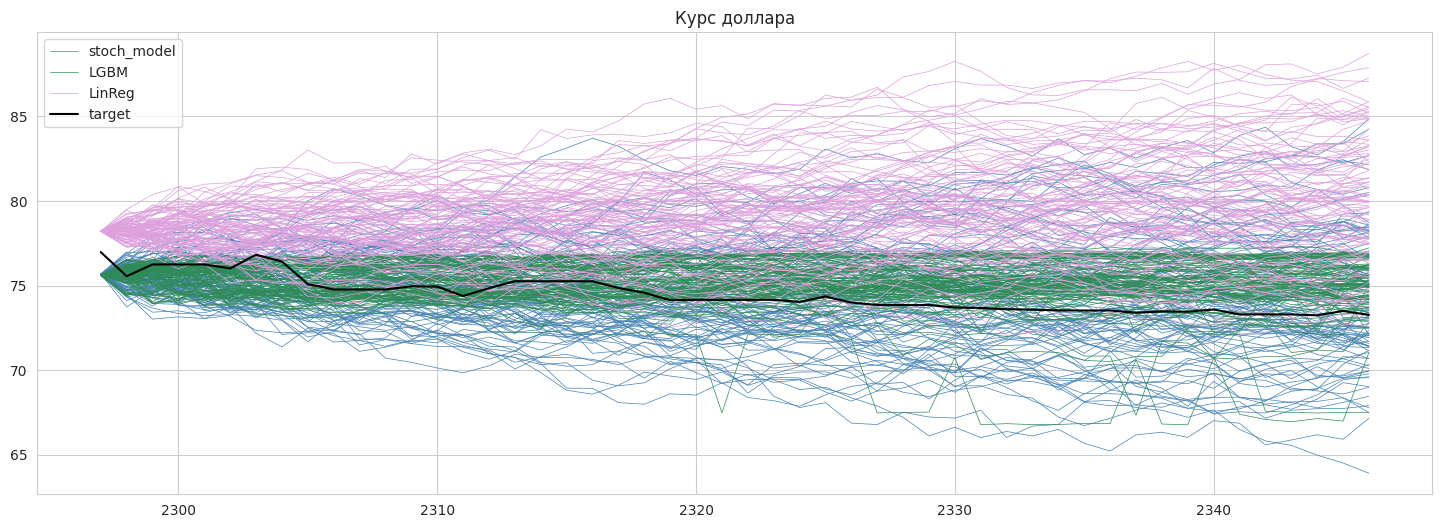

In [ ]:
FV_dol = Fair_value_measurement(target_name=currency[0], factors_name = risk_factors_1, df=data, last_date= '2021-04-15', n_steps=50)
FV_dol.make_predictions(plot=1)

  0%|          | 0/11 [00:00<?, ?it/s]

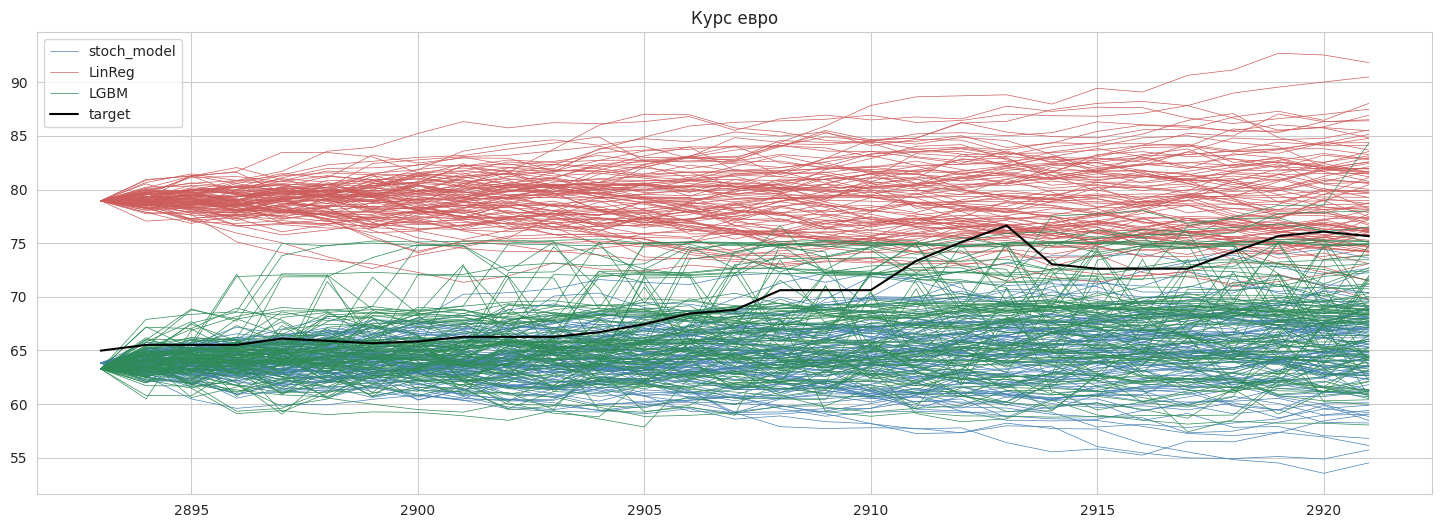

In [ ]:
FV_dol = Fair_value_measurement(target_name=currency[1], factors_name = risk_factors_1, df=data, last_date= '2022-12-02', n_steps=150)
FV_dol.make_predictions(plot=1)

In [ ]:
FV_dol_1 = Fair_value_measurement(target_name=currency[1], factors_name = risk_factors_1, df=data, last_date= '2022-12-02', n_steps=10, N_traj=10)
res1 = FV_dol_1.get_best_prediction()

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
print(res1.shape)

(100, 10)


### Акции

In [ ]:
risk_factors_2 = ['Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС',
       'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 1', 'КБД 5', 'КБД 10', 'КБД 20']

stocks = ['Аэрофлот', 'Газпром', 'ГМК Норникель', 'Лукойл', 'МТС', 'ПИК', 'Роснефть', 'Сбербанк', 'Татнефть', 'Яндекс']

  0%|          | 0/13 [00:00<?, ?it/s]

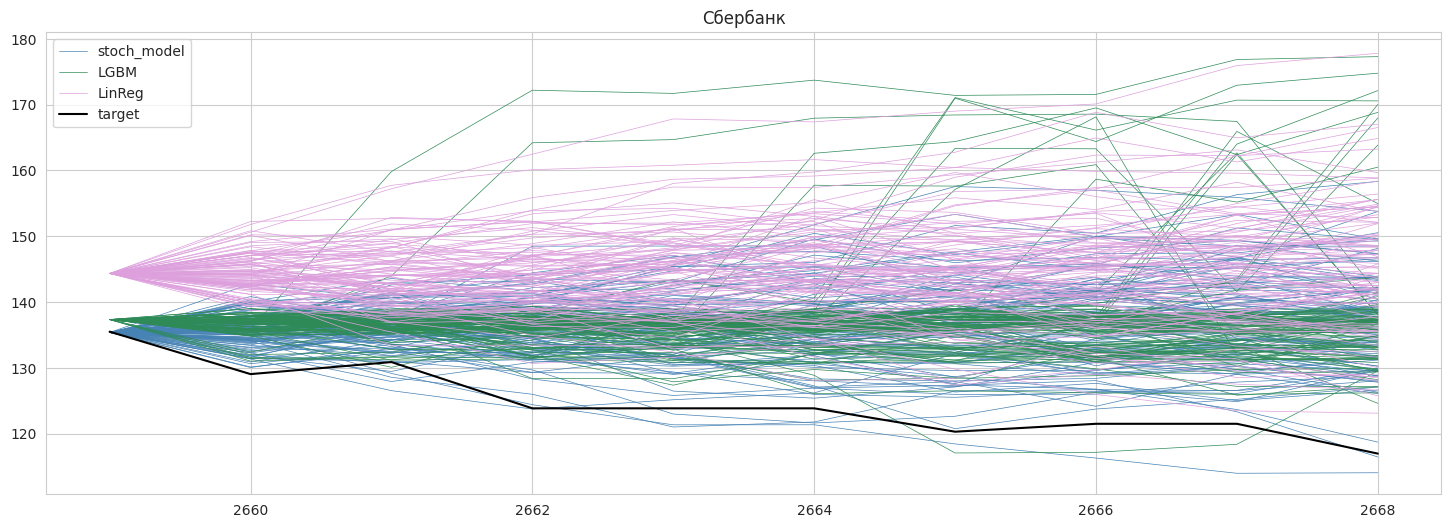

In [ ]:
FV_sber = Fair_value_measurement(target_name=stocks[7], factors_name = risk_factors_2, df=data, last_date= '2022-04-12', n_steps=10)
FV_sber.make_predictions(plot=1)

  0%|          | 0/13 [00:00<?, ?it/s]

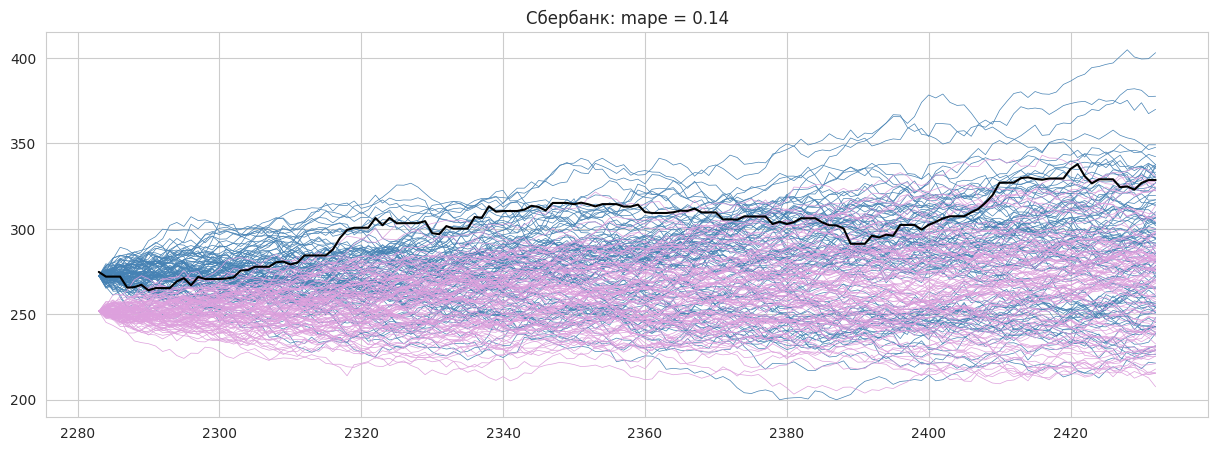

In [ ]:
FV_sber = Fair_value_measurement(target_name=stocks[7], factors_name = risk_factors_2, df=data, last_date= '2021-04-01', n_steps=150)
FV_sber.make_predictions(plot=1)

  0%|          | 0/13 [00:00<?, ?it/s]

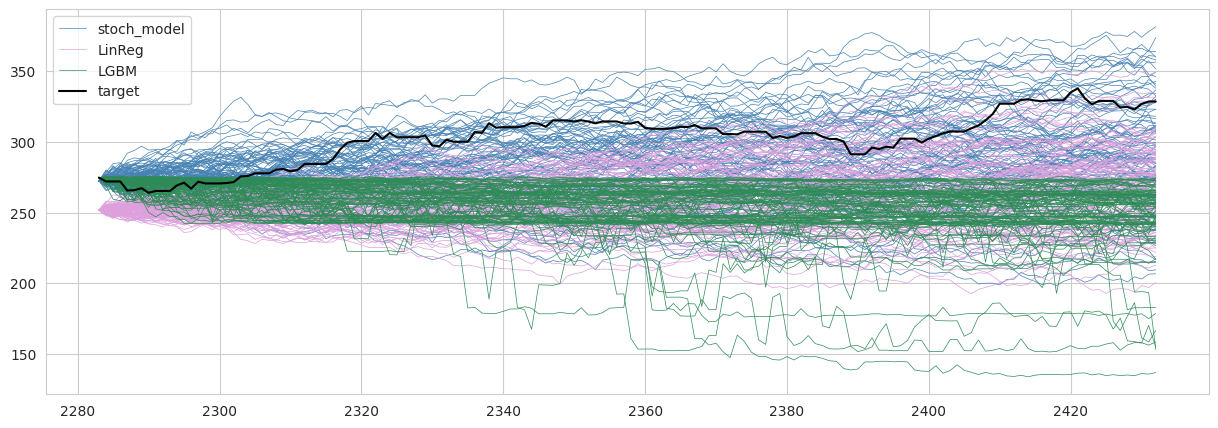

In [ ]:
FV_sber = Fair_value_measurement(target_name=stocks[7], factors_name = risk_factors_2, df=data, last_date= '2021-04-01', n_steps=150)
FV_sber.make_predictions(plot=1)

### Облигации

In [ ]:
bonds = ['ОФЗ_26207', 'ОФЗ_26215', 'ОФЗ_26218', 'ОФЗ_26219', 'ОФЗ_26222']

  0%|          | 0/13 [00:00<?, ?it/s]

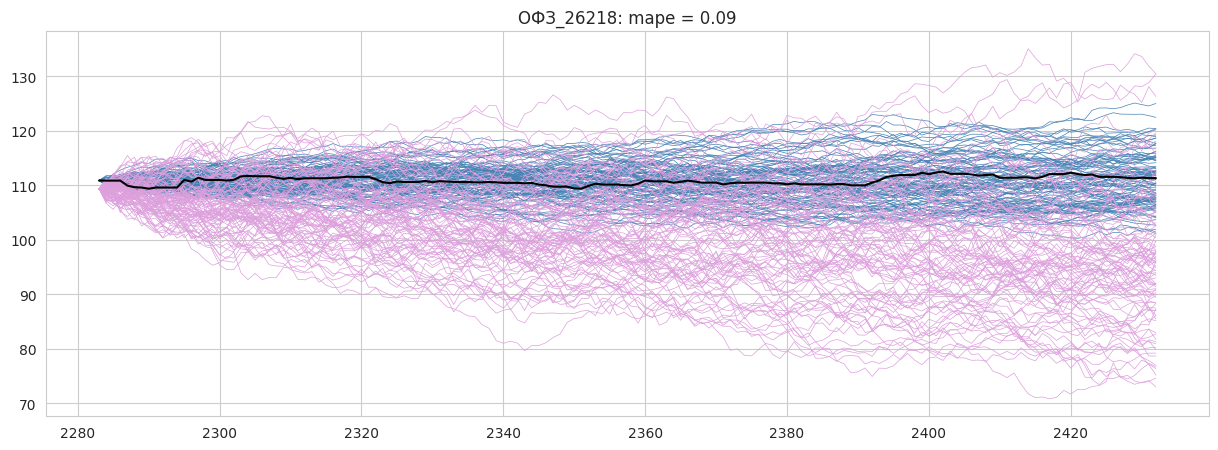

In [ ]:
FV_b18 = Fair_value_measurement(target_name=bonds[2], factors_name = risk_factors_2, df=data, last_date= '2021-04-01', n_steps=150)
FV_b18.make_predictions(plot=1)

  0%|          | 0/13 [00:00<?, ?it/s]

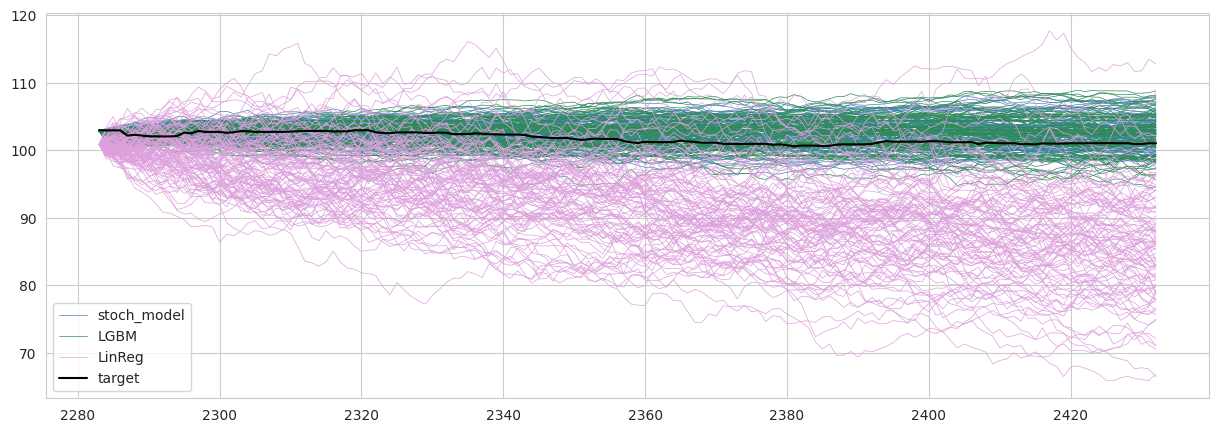

In [ ]:
FV_b22 = Fair_value_measurement(target_name=bonds[4], factors_name = risk_factors_2, df=data, last_date= '2021-04-01', n_steps=150)
FV_b22.make_predictions(plot=1)